<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/dnn_h2o_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Deep Neural Netwotk (DNN) with H20 in R

Zia Ahmed, University at Buffalo

H2O’s Deep Learning is based on a multi-layer feedforward artificial neural network that is trained with stochastic gradient descent using back-propagation. The network can contain a large number of hidden layers consisting of neurons with tanh, rectifier, and maxout activation functions. Advanced features such as adaptive learning rate, rate annealing, momentum training, dropout, L1 or L2 regularization, checkpointing, and grid search enable high predictive accuracy. Each compute node trains a copy of the global model parameters on its local data with multi-threading (asynchronously) and contributes periodically to the global model via model averaging across the network.

### Insatll rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp310-cp310-linux_x86_64.whl


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Packages

In [ ]:
%%R
install.packages(c('tidyverse', 'tidymodels', 'caret', 'Metrics', 'ggmisc', 'vip'), lib='drive/My Drive/R/', repos='http://cran.rstudio.com/')


#### Install h2o

In [ ]:
%%R
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

### Load Packages

In [3]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



### Data

In this exercise we will use following synthetic data set and use  DEM, Slope,  TPI, MAT, MAP, NDVI, NLCD, FRG to fit Deep Neural Network regression model. This data was created with AI using gp_soil_data data set

[gp_soil_data_syn.csv](https://www.dropbox.com/s/c63etg7u5qql2y8/gp_soil_data_syn.csv?dl=0)

In [4]:
%%R
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data_syn.csv"
mf<-read_csv(url(urlfile))
#mf<-read_csv("/content/sample_data/gp_soil_data_syn.csv")
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 1408 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): NLCD, FRG
dbl (8): ID, SOC, DEM, Slope, TPI, MAP, MAT, NDVI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1,408
Columns: 9
$ SOC   <dbl> 1.900, 2.644, 0.800, 0.736, 15.641, 8.818, 3.782, 6.641, 4.803, …
$ DEM   <dbl> 2825.1111, 2535.1086, 1716.3300, 1649.8933, 2675.3113, 2581.4839…
$ Slope <dbl> 18.981682, 14.182393, 1.585145, 9.399726, 12.569353, 6.358553, 1…
$ TPI   <dbl> -0.91606224, -0.15259802, -0.39078590, -2.54008722, 7.40076303, …
$ MAT   <dbl> 4.709227, 4.648000, 6.360833, 10.265385, 2.798550, 6.358550, 7.0…
$ MAP   <dbl> 613.6979, 597.7912, 201.5091, 298.2608, 827.4680, 679.1392, 508.…
$ NDVI  <dbl> 0.6845260, 0.7557631, 0.2215059, 0.2785148, 0.7337426, 0.7017139…
$ NLCD  <chr> "Forest", "Forest", "Shrubland", "Shrubland", "Forest", "For

### Data Preprocessing

#### Convert to factor

In [5]:
%%R
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Data Split

In [11]:
%%R
set.seed(1245)   # for reproducibility
split_01 <- initial_split(df, prop = 0.7, strata = SOC)
train <- split_01 %>% training()
test_valid <-  split_01 %>% testing()

split_02 <- initial_split(test_valid, prop = 0.5, strata = SOC)
test <- split_02 %>% training()
valid <-  split_02 %>% testing()

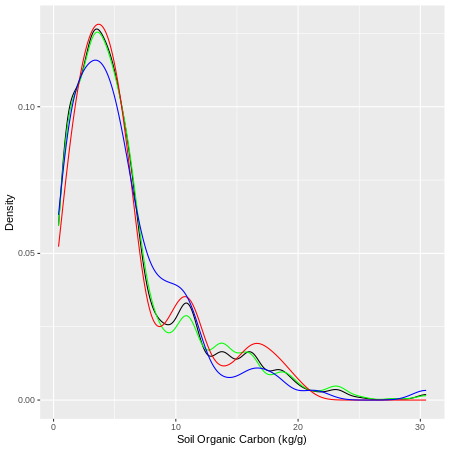

In [12]:
%%R -w 450 -h 450 -u px
# Density plot all, train and test data
ggplot()+
  geom_density(data = df, aes(SOC))+
  geom_density(data = train, aes(SOC), color = "green")+
  geom_density(data = test, aes(SOC), color = "red") +
  geom_density(data = valid, aes(SOC), color = "blue") +
      xlab("Soil Organic Carbon (kg/g)") +
     ylab("Density")

#### Data Scaling

### Import h20

In [7]:
%%R
.libPaths('drive/My Drive/R')
library(h2o)
h2o.init()
#disable progress bar
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’



    day, hour, month, week, year



    cor, sd, var



    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc





H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmpi3B1OC/file89342b1c4f2/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmpi3B1OC/file89318cdf25/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ........................... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 389 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.42.0.2 
    H2O cluster version age:    28 days, 14 hours and 55 minutes 
    H2O cluster name:           H2O_started_from_R_root_yqz807 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Secu

### Import data to h2o cluster

In [13]:
%%R
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)
h_valid = as.h2o(valid)

In [15]:
%%R
CV.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

#### Define response and predictors

In [16]:
%%R
y <- "SOC"
x <- setdiff(names(h_df), y)

## Fit DNN model with few fixed prameters

First we fit DNN model with following parameters:

standardize: logical. If enabled, automatically standardize the data.

distribution:

activation: Specify the activation function. One of:

  - tanh
  
  - tanh_with_dropout
  
  - rectifier (default)
  
  - rectifier_with_dropout

  - maxout (not supported when autoencoder is enabled)
  
  - maxout_with_dropout
  
hidden: Specify the hidden layer sizes (e.g., (100,100)). The value must be positive. This option defaults to (200,200).

adaptive_rate: Specify whether to enable the adaptive learning rate (ADADELTA). This option defaults to True (enabled).

epochs: Specify the number of times to iterate (stream) the dataset. The value can be a fraction. This option defaults to 10.

epsilon: (Applicable only if adaptive_rate=True) Specify the adaptive learning rate time smoothing factor to avoid dividing by zero. This option defaults to 1e-08.

input_dropout_ratio: Specify the input layer dropout ratio to improve generalization. Suggested values are 0.1 or 0.2. This option defaults to 0.

l1: Specify the L1 regularization to add stability and improve generalization; sets the value of many weights to 0 (default).

l2: Specify the L2 regularization to add stability and improve generalization; sets the value of many weights to smaller values. Defaults to 0.

max_w2: Specify the constraint for the squared sum of the incoming weights per unit (e.g. for rectifier). Defaults to 3.4028235e+38.

momentum_start: (Applicable only if adaptive_rate=False) Specify the initial momentum at the beginning of training; we suggest 0.5. This option defaults to 0.

rate: (Applicable only if adaptive_rate=False) Specify the learning rate. Higher values result in a less stable model, while lower values lead to slower convergence. This option defaults to 0.005.

rate_annealing: Learning rate decay, (Applicable only if adaptive_rate=False) Specify the rate annealing value. rate(1+ rate_annealing × samples), This option defaults to 1e-06.

rate_decay: (Applicable only if adaptive_rate=False) Specify the rate decay factor between layers. N-th layer: rate × rate_decay(n−1). This options defaults to 1.

regression_stop: (Regression models only) Specify the stopping criterion for regression error (MSE) on the training data. When the error is at or below this threshold, training stops. To disable this option, enter -1. This option defaults to 1e-06.

rho: (Applicable only if adaptive_rate is enabled) Specify the adaptive learning rate time decay factor. This option defaults to 0.99.

shuffle_training_data: Specify whether to shuffle the training data. This option is recommended if the training data is replicated and the value of train_samples_per_iteration is close to the number of nodes times the number of rows. This option defaults to False (disabled).

stopping_tolerance = Relative tolerance for metric-based stopping criterion

stopping_rounds = Early stopping based on convergence of stopping_metric.Defaults to 5.

stopping_metric = Metric to use for early stopping

variable_importances: Specify whether to compute variable importance. This option defaults to True (enabled).

In [17]:
%%R
DNN <- h2o.deeplearning(
                       model_id="DNN_model_ID",
                       training_frame=h_train,
                       validation_frame=h_valid,
                       x=x,
                       y=y,
                       distribution ="AUTO",
                       standardize = TRUE,
                       shuffle_training_data = TRUE,
                       activation = "tanh",
                       hidden = c(100, 100, 100),
                       epochs = 500,
                       adaptive_rate = TRUE,
                       rate = 0.005,
                       rate_annealing = 1e-06,
                       rate_decay = 1,
                       rho = 0.99,
                       epsilon = 1e-08,
                       momentum_start = 0.5,
                       momentum_stable =0.99,
                       input_dropout_ratio = 0.0001,
                       regression_stop = 1e-06,
                       l1 = 0.0001,
                       l2 = 0.0001,
                       max_w2 = 3.4028235e+38,
                       stopping_tolerance = 0.001,
                       stopping_rounds = 3,
                       stopping_metric = "RMSE",
                       nfolds = 5,
                       keep_cross_validation_models = TRUE,
                       keep_cross_validation_predictions = TRUE,
                       variable_importances = TRUE,
                       seed=1256
                       )

###  Scoring History

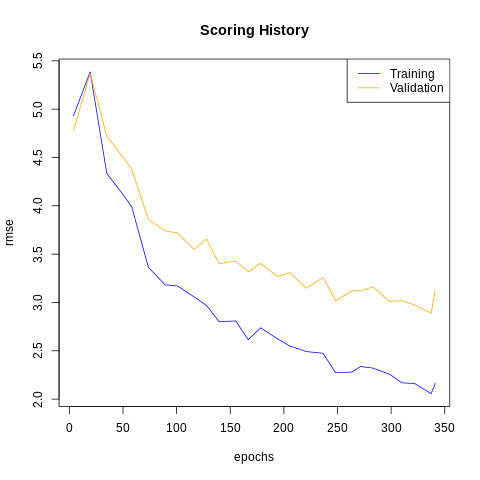

In [18]:
%%R -w 450 -h 450 -u px
plot(DNN)


### Model Performance

#### Training Performance

In [19]:
%%R
h2o.performance(DNN,  h_train)

H2ORegressionMetrics: deeplearning

MSE:  4.67707
RMSE:  2.162653
MAE:  1.479348
RMSLE:  NaN
Mean Residual Deviance :  4.67707



### Cross-validation performance

In [20]:
%%R
h2o.performance(DNN,  xval=TRUE)

H2ORegressionMetrics: deeplearning
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  18.6259
RMSE:  4.315774
MAE:  2.845425
RMSLE:  NaN
Mean Residual Deviance :  18.6259



#### Validation data

In [21]:
%%R
h2o.performance(DNN,  h_valid)

H2ORegressionMetrics: deeplearning

MSE:  9.751439
RMSE:  3.122729
MAE:  2.054488
RMSLE:  NaN
Mean Residual Deviance :  9.751439



#### Test data

In [23]:
%%R
h2o.performance(DNN,  h_test)

H2ORegressionMetrics: deeplearning

MSE:  8.728889
RMSE:  2.954469
MAE:  1.982908
RMSLE:  NaN
Mean Residual Deviance :  8.728889



### Prediction

In [24]:
%%R
# test - prediction
test.pred.DNN<-as.data.frame(h2o.predict(object = DNN, newdata = h_test))
test.xy$DNN_SOC<-test.pred.DNN$predict

In [26]:
%%R
RMSE<- Metrics::rmse(test.xy$SOC, test.xy$DNN_SOC)
paste0("RMSE: ", round(RMSE,2))


[1] "RMSE: 2.95"


In [28]:
%%R
MAE<- Metrics::mae(test.xy$SOC, test.xy$DNN_SOC)
paste0("MAE: ", round(MAE,2))

[1] "MAE: 1.98"


In [ ]:
%%R
.libPaths('drive/My Drive/R')
library(ggpmisc)

`geom_smooth()` using formula = 'y ~ x'


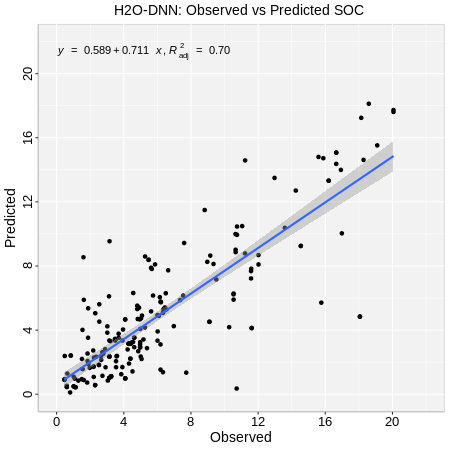

In [30]:
%%R -w 450 -h 450 -u px

formula<-y~x

ggplot(test.xy, aes(SOC,DNN_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O-DNN: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,22), breaks=seq(0, 22, 4))+
  scale_y_continuous(limits=c(0,22), breaks=seq(0, 22, 4)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Fit the Best DNN model with hyperparameter tunning

H2O Grid Search is a hyperparameter optimization technique in the H2O machine learning framework. It involves a systematic search through a specified subset of hyperparameters of a machine learning model to find the optimal combination of hyperparameters that maximizes the performance metric of interest, such as RMSE or AUC.

H2O supports two types of grid search: traditional (or "cartesian") and random. In a cartesian grid search, users specify a set of values for each hyperparameter that they want to search over, and H2O will train a model for every combination of the hyperparameter values. This means that if you have three hyperparameters and you specify 5, 10, and 2 values for each, your grid will contain a total of 5*10*2 = 100 models.


### Define DNN Hyper-parameters

In [31]:
%%R
DNN_hyper_params <- list(
                     activation = c("Rectifier",
                                    "Maxout",
                                    "Tanh",
                                    "RectifierWithDropout",
                                    "MaxoutWithDropout",
                                    "TanhWithDropout"),
                     hidden = list( c(50, 50, 50, 50),
                                   c(100, 100, 100), c(200, 200, 200)),
                     epochs = c(50, 100, 200, 500),
                     l1 = c(0, 0.00001, 0.0001),
                     l2 = c(0, 0.00001, 0.0001),
                     rate = c(0, 01, 0.005, 0.001),
                     rate_decay = c(0.5, 1.0, 1.5),
                     rate_annealing = c(1e-5, 1e-6, 1e-5),
                     rho = c(0.9, 0.95, 0.99, 0.999),
                     epsilon = c(1e-06, 1e-08, 1e-09),
                     momentum_start = c(0, 0.5),
                     momentum_stable = c(0.99, 0.5, 0),
                     regression_stop = c(1e-05, 1e-06,1e-07),
                     input_dropout_ratio = c(0, 0.0001, 0.001),
                     max_w2 = c(10, 100, 1000, 3.4028235e+38)
                     )

#### Search criterias

In [32]:
%%R
DNN_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 200,
                        max_runtime_secs = 900,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 3,
                        seed = 1345767)

### Grid Search for the best parameters

In [33]:
%%R
DNN_grid <- h2o.grid(
                  algorithm="deeplearning",
                  grid_id = "DNN_grid_IDs",
                  x= x,
                  y = y,
                  standardize = TRUE,
                  shuffle_training_data = TRUE,
                  training_frame = h_train,
                  validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  nfolds= 5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = DNN_hyper_params,
                  search_criteria = DNN_search_criteria,
                  seed = 42)

### The Best DNN

In [34]:
%%R
# number DNN models
length(DNN_grid@model_ids)
# Get  Model ID
DNN_get_grid <- h2o.getGrid("DNN_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
# Get the best DNN model
best_DNN <- h2o.getModel(DNN_get_grid@model_ids[[1]])
best_DNN

Model Details:

H2ORegressionModel: deeplearning
Model ID:  DNN_grid_IDs_model_5 
Status of Neuron Layers: predicting SOC, regression, gaussian distribution, Quadratic loss, 22,201 weights/biases, 268.9 KB, 44,235 training samples, mini-batch size 1
  layer units   type dropout       l1       l2 mean_rate rate_rms momentum
1     1    18  Input  0.01 %       NA       NA        NA       NA       NA
2     2   100   Tanh  0.00 % 0.000000 0.000010  0.124553 0.311778 0.000000
3     3   100   Tanh  0.00 % 0.000000 0.000010  0.044117 0.017812 0.000000
4     4   100   Tanh  0.00 % 0.000000 0.000010  0.095748 0.076825 0.000000
5     5     1 Linear      NA 0.000000 0.000010  0.003238 0.001210 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2   -0.002813   0.200844 -0.013444 0.093876
3    0.000604   0.166371  0.007647 0.219199
4    0.000060   0.160166 -0.051194 0.258669
5    0.001715   0.126749  0.071070 0.000000


H2ORegressionMetrics: deeplearning

### Model performance

In [35]:
%%R
h2o.performance(best_DNN, h_train)
# CV-performance
h2o.performance(best_DNN, xval=TRUE)
# validation performance
h2o.performance(best_DNN, h_valid)
# test performance
h2o.performance(best_DNN, h_test)

H2ORegressionMetrics: deeplearning

MSE:  14.51461
RMSE:  3.809804
MAE:  2.481798
RMSLE:  0.5984666
Mean Residual Deviance :  14.51461



### Prediction

In [37]:
%%R
test.pred.best_DNN<-as.data.frame(h2o.predict(object = best_DNN, newdata = h_test))
test.xy$best_DNN_SOC<-test.pred.best_DNN$predict

`geom_smooth()` using formula = 'y ~ x'


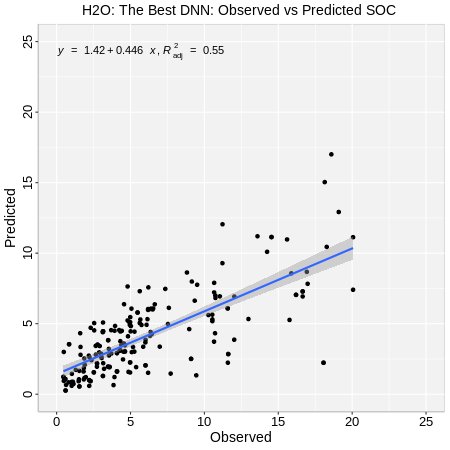

In [44]:
%%R -w 450 -h 450 -u px

formula<-y~x

ggplot(test.xy, aes(SOC, best_DNN_SOC)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O: The Best DNN: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

#### Model Explainability

Model explainability refers to the ability to understand and interpret the decisions made by a machine learning model. In other words, it is the ability to explain how a model arrives at its predictions or classifications.

Explainability is particularly important in applications where decisions made by the model have significant real-world consequences, such as in healthcare, finance, and legal fields. It is also important for regulatory compliance, where models must be auditable and transparent.

The h2o.explain() function generates a list of explanations -- individual units of explanation such as a Partial Dependence plot or a Variable Importance plot. Most of the explanations are visual -- these plots can also be created by individual utility functions outside the h2o.explain() function.

#### Retrieve the variable importance

In [45]:
%%R
h2o.varimp(best_DNN)

Variable Importances: 
                    variable relative_importance scaled_importance percentage
1                        MAP            1.000000          1.000000   0.093594
2                       NDVI            0.931706          0.931706   0.087202
3                NLCD.Forest            0.771512          0.771512   0.072209
4                      Slope            0.746839          0.746839   0.069900
5                        MAT            0.742411          0.742411   0.069485
6             NLCD.Shrubland            0.736031          0.736031   0.068888
7    NLCD.Planted/Cultivated            0.706913          0.706913   0.066163
8    FRG.Fire Regime Group V            0.633184          0.633184   0.059262
9                        TPI            0.603650          0.603650   0.056498
10   FRG.Fire Regime Group I            0.592470          0.592470   0.055452
11                       DEM            0.586770          0.586770   0.054918
12           NLCD.Herbaceous            0

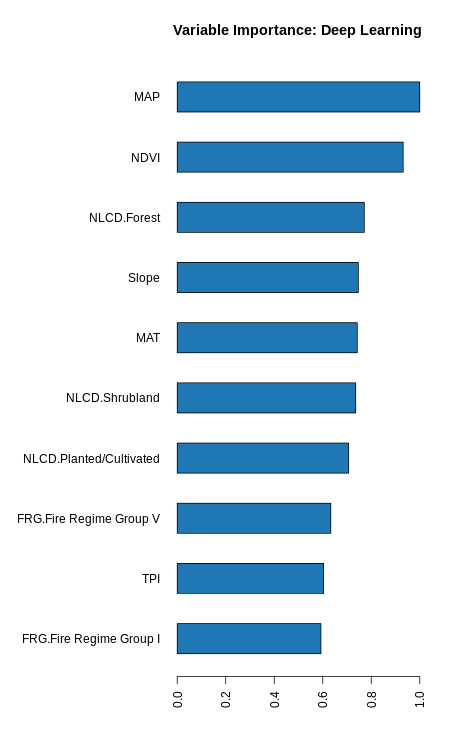

In [48]:
%%R -w 450 -h 750 -u px
h2o.varimp_plot(best_DNN)

#### Partial Dependence (PD) Plots

A partial dependence plot (PDP) is a graphical tool for understanding the relationship between a particular input feature and the output of a machine learning model.

A PDP shows the marginal effect of a single feature on the predicted outcome while holding all other features at a fixed value or their average value. The PDP can help to visualize the shape and direction of the relationship between the feature and the output, and can also help to identify any non-linearities or interactions between the feature and other features in the model.

To create a PDP, the value of the feature of interest is varied over its range, and the model's predicted output is recorded for each value. The resulting data is then plotted on a graph, with the feature's value on the x-axis and the predicted output on the y-axis.

PDPs can be used to gain insights into how a model is making its predictions and to identify which features are most important for the model's output. They can also be used to identify potential biases in the model or to detect interactions between features that may be difficult to detect using other methods.

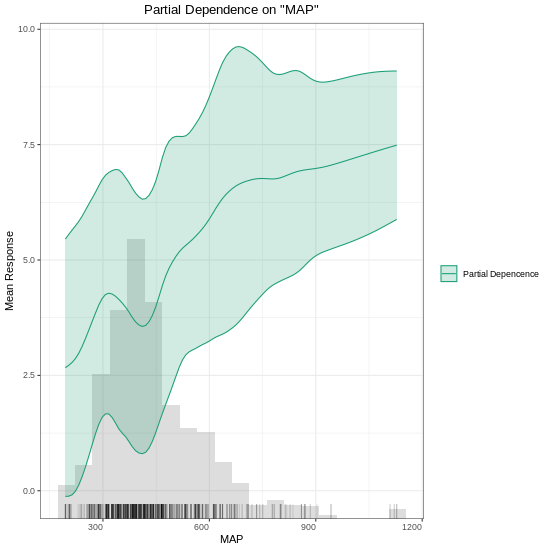

In [54]:
%%R -w 550 -h 550 -u px
h2o.pd_multi_plot(best_DNN, h_train, "MAP")

#### Residual Analysis

Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable

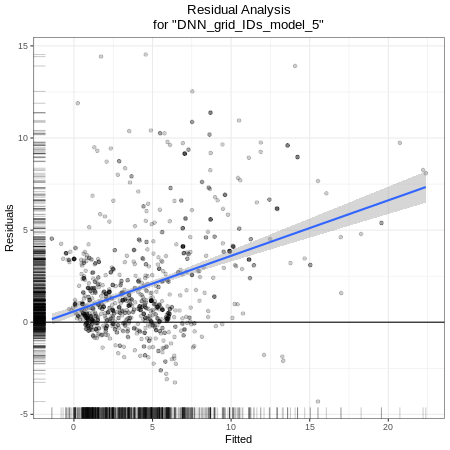

In [53]:
%%R -w 450 -h 450 -u px
h2o.residual_analysis_plot(best_DNN, h_train)


### Further Reading

1. [Deep Learning (Neural Networks](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#quick-start-and-additional-resources)


2. [Classification and Regression with H2O Deep Learning](https://h2o.gitbooks.io/h2o-tutorials/content/tutorials/deeplearning/)